Filter and Merge Extracted Interactions
===

Builds on the three `Extraction` jupyter notebooks in this directory.



In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import re
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
import sqlite3
from nltk import word_tokenize
from html.parser import HTMLParser
from tqdm import tqdm
import random
import pickle
import json

from datetime import datetime
from pprint import pprint

import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pylab as pl
from IPython.core.display import display, HTML

In [3]:
from pathlib import Path
git_root_dir = !git rev-parse --show-toplevel
git_root_dir = Path(git_root_dir[0].strip())
git_root_dir

PosixPath('/panfs/roc/groups/3/srivbane/levon003/repos/sna-social-support')

In [4]:
import sys
caringbridge_core_path = "/home/srivbane/levon003/repos/caringbridge_core"
sys.path.append(caringbridge_core_path)

In [5]:
import cbcore.data.paths as paths
import cbcore.data.dates as dates

In [6]:
working_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/csv_data"
assert os.path.exists(working_dir)

### Load valid user list

We start by filtering only to include interactions contained in the list of valid users.

In [7]:
# load the list of valid users
data_selection_working_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/data_selection"
valid_user_ids = set()
with open(os.path.join(data_selection_working_dir, "valid_user_ids.txt"), 'r') as infile:
    for line in infile:
        user_id = line.strip()
        if user_id == "":
            continue
        else:
            valid_user_ids.add(int(user_id))
len(valid_user_ids)

362370

### Filter raw interactions files

Filters each interactions file to include only selected users.

We filter first to greatly reduce the size of the data when we subsequently merge.

In [10]:
gb_filepath = os.path.join(working_dir, "old_gb_metadata_raw.csv")
comments_filepath = os.path.join(working_dir, "new_comments_metadata_raw.csv")
amps_filepath = os.path.join(working_dir, "new_amps_metadata_raw.csv")

gb_filtered_filepath = os.path.join(working_dir, "old_gb_metadata_filtered.csv")
comments_filtered_filepath = os.path.join(working_dir, "new_comments_metadata_filtered.csv")
amps_filtered_filepath = os.path.join(working_dir, "new_amps_metadata_filtered.csv")

In [14]:
for input_filepath, output_filepath in [(gb_filepath, gb_filtered_filepath), 
                                        (comments_filepath, comments_filtered_filepath), 
                                        (amps_filepath, amps_filtered_filepath)]:
    with open(input_filepath, 'r') as infile:
        with open(output_filepath, 'w') as outfile:
            for line in tqdm(infile, desc=os.path.basename(input_filepath)):
                if line.strip() == "":
                    continue
                user_id = int(line.split(",")[0])
                if user_id in valid_user_ids:
                    outfile.write(line)
                
print("Finished filtering files.")

old_gb_metadata_raw.csv: 82980359it [01:59, 695570.18it/s]
new_comments_metadata_raw.csv: 31052715it [00:48, 645155.79it/s]
new_amps_metadata_raw.csv: 63314738it [01:51, 567768.46it/s]


Finished filtering files.


Pre- and post-filtering word counts:
```
   63314738 new_amps_metadata_raw.csv
   31052715 new_comments_metadata_raw.csv
   82980359 old_gb_metadata_raw.csv
   
    3536819 new_amps_metadata_filtered.csv
    1094435 new_comments_metadata_filtered.csv
    5864304 old_gb_metadata_filtered.csv

```

In [16]:
# proportion of remaining lines for amps, comments, and the guestbook respectively
3536819 / 63314738, 1094435 / 31052715, 5864304 / 82980359

(0.05586091187805278, 0.03524442226710289, 0.07067098854079433)

### Read interactions data

In [8]:
gb_cols = ['user_id', 'site_id', 'int_type', 'created_at', 'updated_at']
comments_cols = ['user_id','site_id','int_type','journal_oid','created_at','updated_at']
amps_cols = ['user_id','site_id','journal_oid','journal_user_id','created_at','updated_at']

In [11]:
s = datetime.now()
gb_df = pd.read_csv(gb_filtered_filepath, header=None, names=gb_cols)
print(datetime.now() - s)
len(gb_df)

0:00:05.436972


5864304

In [12]:
s = datetime.now()
comments_df = pd.read_csv(comments_filtered_filepath, header=None, names=comments_cols)
print(datetime.now() - s)
len(comments_df)

0:00:02.024165


1094435

In [13]:
s = datetime.now()
amps_df = pd.read_csv(amps_filtered_filepath, header=None, names=amps_cols)
print(datetime.now() - s)
len(amps_df)

/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


0:00:05.548678


3536819

### Plot interactions overlaps

Takes a user view of interactions, producing visualizations to understand user types more broadly.

In [14]:
gb_user_ids = set(gb_df.user_id)
comments_user_ids = set(comments_df.user_id)
amps_user_ids = set(amps_df.user_id)
len(gb_user_ids), len(comments_user_ids), len(amps_user_ids)

(226049, 120020, 133612)

In [15]:
total_user_count = len(gb_user_ids | comments_user_ids | amps_user_ids)
total_user_count

275291

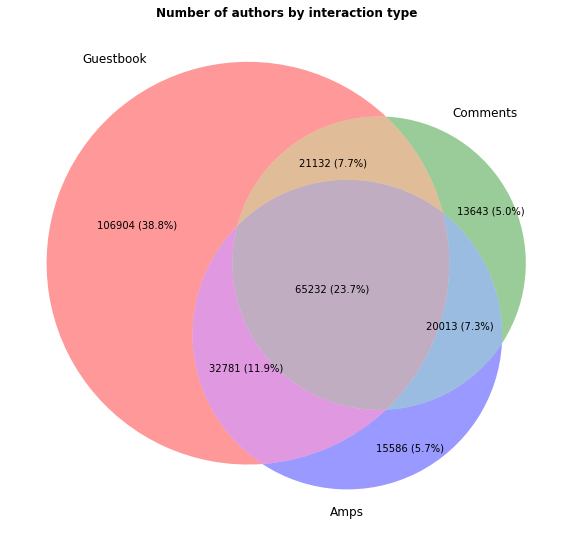

In [16]:
from matplotlib_venn import venn3
fig, ax = plt.subplots(1, 1, figsize=(10,10))
venn3([gb_user_ids, comments_user_ids, amps_user_ids], set_labels=['Guestbook', 'Comments', 'Amps'], ax=ax,
     subset_label_formatter=lambda label: f"{label} ({int(label)/total_user_count*100:.1f}%)")
plt.title("Number of authors by interaction type", fontweight='bold')
plt.show()

In [17]:
gb_counts = defaultdict(int)
for user_id in tqdm(gb_df.user_id):
    gb_counts[user_id] += 1

100%|██████████| 5864304/5864304 [00:03<00:00, 1568665.62it/s]


In [18]:
comments_counts = defaultdict(int)
for user_id in tqdm(comments_df.user_id):
    comments_counts[user_id] += 1

100%|██████████| 1094435/1094435 [00:00<00:00, 1321159.30it/s]


In [19]:
amps_counts = defaultdict(int)
for user_id in tqdm(amps_df.user_id):
    amps_counts[user_id] += 1

100%|██████████| 3536819/3536819 [00:02<00:00, 1544344.45it/s]


In [20]:
users = []
for user_id in tqdm(gb_user_ids | comments_user_ids | amps_user_ids):
    u = {
        'user_id': user_id,
        'total_guestbook_count': gb_counts[user_id],
        'total_comments_count': comments_counts[user_id],
        'total_amps_count': amps_counts[user_id]
    }
    users.append(u)
len(users)

100%|██████████| 275291/275291 [00:00<00:00, 390957.19it/s]


275291

In [21]:
user_ints_df = pd.DataFrame(users)
len(user_ints_df)

275291

In [22]:
user_ints_df.head()

,total_amps_count,total_comments_count,total_guestbook_count,user_id
0,22,5,3,3145728
1,0,0,1,1
2,0,0,47,2
3,0,2,3,1048579
4,0,0,1,6


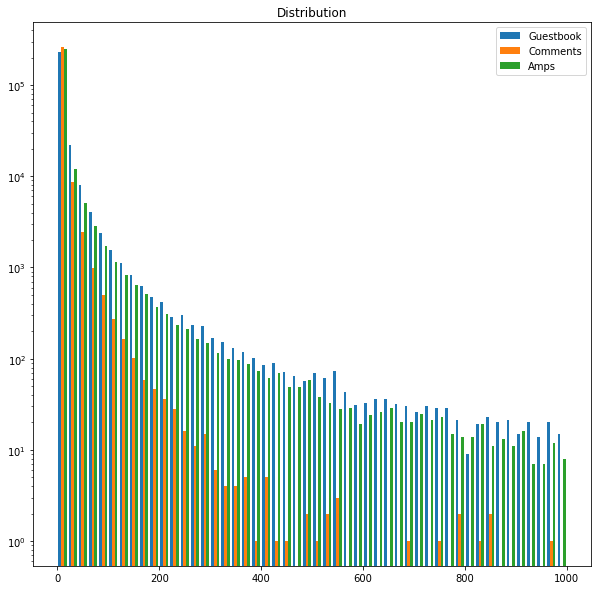

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.hist([user_ints_df.total_guestbook_count, user_ints_df.total_comments_count, user_ints_df.total_amps_count], 
        log=True, bins=50, range=(0,1000), label=['Guestbook', 'Comments', 'Amps'])
plt.title("Distribution")
plt.legend()
plt.show()

In [128]:
# 95th, 99th, and 99.9th percentile for guestbook activity
np.quantile(user_ints_df.total_guestbook_count, 0.95), np.quantile(user_ints_df.total_guestbook_count, 0.99), np.quantile(user_ints_df.total_guestbook_count, 0.999)

(64.0, 265.0, 1679.1300000000629)

In [129]:
# 95th, 99th, and 99.9th percentile for comments activity
np.quantile(user_ints_df.total_comments_count, 0.95), np.quantile(user_ints_df.total_comments_count, 0.99), np.quantile(user_ints_df.total_comments_count, 0.999)

(19.0, 54.0, 156.0)

In [130]:
# 95th, 99th, and 99.9th percentile for amps activity
np.quantile(user_ints_df.total_amps_count, 0.95), np.quantile(user_ints_df.total_amps_count, 0.99), np.quantile(user_ints_df.total_amps_count, 0.999)

(46.0, 189.0, 970.4200000000419)

In [134]:
user_ints_df[user_ints_df.total_comments_count >= 500].head()

,total_amps_count,total_comments_count,total_guestbook_count,user_id
9072,2183,1031,6,27295957
29123,39769,1336,896,107444
49341,1261,855,91,1232796
59758,2835,1445,11908,4417989
66896,11,510,80,6541679


#### We now cluster and plot the interaction totals to try to uncover additional structure

In [42]:
import sklearn

In [45]:
X = user_ints_df[['total_guestbook_count', 'total_comments_count', 'total_amps_count']].values
X.shape

(275291, 3)

In [46]:
import umap

In [47]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(X)
embedding.shape
# we don't visualize these embeddings until after we cluster, in order to compare the 3d-clustering to the 2d embedding

/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 637 separate connected components using meta-embedding (experimental)
  n_components
/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


(275291, 2)

In [71]:
# we cluster the user interactions using DBSCAN
import sklearn.cluster
dbscan = sklearn.cluster.DBSCAN(n_jobs=-1)
clusters = dbscan.fit_predict(np.log(X + 1))

In [72]:
Counter(clusters).most_common()

[(1, 106904),
 (0, 64916),
 (3, 32751),
 (2, 21119),
 (4, 20007),
 (5, 15586),
 (6, 13642),
 (-1, 320),
 (7, 9),
 (8, 6),
 (13, 6),
 (9, 5),
 (10, 4),
 (16, 4),
 (11, 4),
 (14, 4),
 (15, 3),
 (12, 1)]

In [79]:
cluster_counter = Counter(clusters)

In [74]:
num_clusters = len(set(clusters))
num_clusters

18

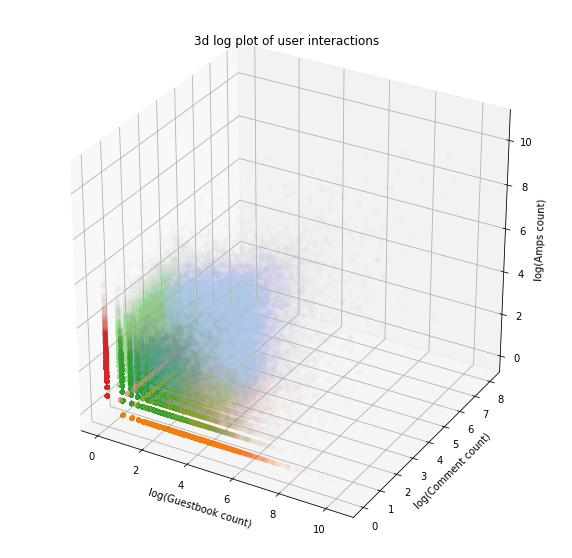

In [121]:
from mpl_toolkits.mplot3d import Axes3D
fig, ax = plt.subplots(1, 1, figsize=(10,10), subplot_kw={'projection': '3d'})
colors=[plt.cm.tab20((cluster + 1) / num_clusters) for cluster in clusters]
ax.scatter(np.log(X[:, 0] + 1), np.log(X[:, 1] + 1), zs=np.log(X[:, 2] + 1), alpha=0.01, c=colors)
plt.title("3d log plot of user interactions")
ax.set_xlabel("log(Guestbook count)")
ax.set_ylabel("log(Comment count)")
ax.set_zlabel("log(Amps count)")
plt.show()

In [ ]:
# we create a 360 degree movie of this visualization by saving each frame
# SO source: https://stackoverflow.com/a/12905458/4146714
# this took 2:14:39 to execute the first time
visualization_working_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/visualization"
user_interactions_movie_dir = os.path.join(visualization_working_dir, 'user_interactions_movie')
os.makedirs(user_interactions_movie_dir, exist_ok=True)

fig, ax = plt.subplots(1, 1, figsize=(10,10), subplot_kw={'projection': '3d'})
colors=[plt.cm.tab20((cluster + 1) / num_clusters) for cluster in clusters]
ax.scatter(np.log(X[:, 0] + 1), np.log(X[:, 1] + 1), zs=np.log(X[:, 2] + 1), alpha=0.01, c=colors)
ax.set_xlabel("log(Guestbook count)")
ax.set_ylabel("log(Comment count)")
ax.set_zlabel("log(Amps count)")

elev=10

for ii in tqdm(range(0,360,1), desc='Rendering frames.'):
    ax.view_init(elev=None, azim=ii)
    # default DPI is 100
    plt.savefig(os.path.join(user_interactions_movie_dir, f"f{ii}.png"))

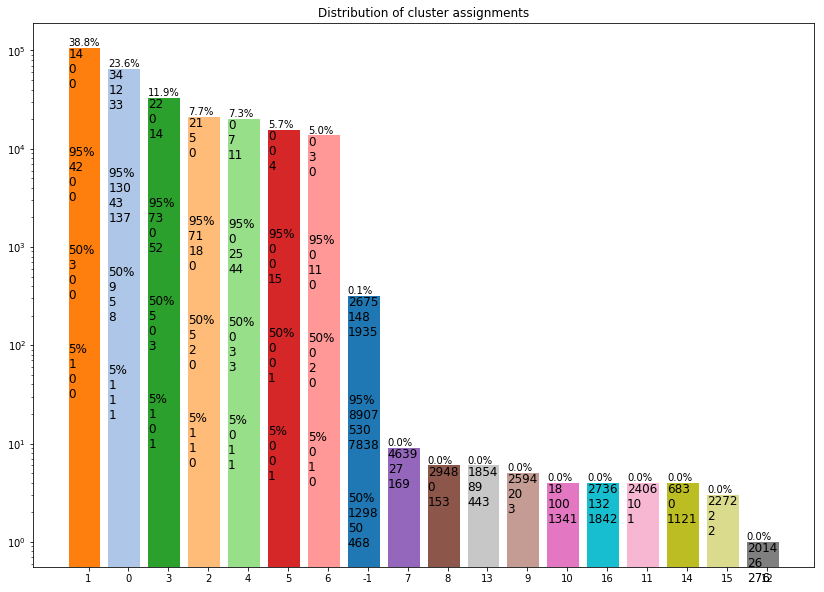

In [115]:
from mpl_toolkits.mplot3d import Axes3D
fig, ax = plt.subplots(1, 1, figsize=(14,10))
ax.set_title("Distribution of cluster assignments")
ax.bar(range(num_clusters), [count for clust, count in Counter(clusters).most_common()],
      color=[plt.cm.tab20((clust + 1) / num_clusters) for clust, count in Counter(clusters).most_common()], 
       align='edge')
ax.set_xticks(np.array(range(num_clusters)) + 0.5)
ax.set_xticklabels([str(clust) for clust, count in Counter(clusters).most_common()])
for i, tup in enumerate(Counter(clusters).most_common()):
    clust, count = tup
    m = np.mean(X[clusters == clust, :], axis=0)
    med = np.median(X[clusters == clust, :], axis=0)
    ql = np.quantile(X[clusters == clust, :], 0.05, axis=0)
    qh = np.quantile(X[clusters == clust, :], 0.95, axis=0)
    s = np.std(X[clusters == clust, :], axis=0)
    text = f"{m[0]:.0f}\n{m[1]:.0f}\n{m[2]:.0f}"
    text_med = f"50%\n{med[0]:.0f}\n{med[1]:.0f}\n{med[2]:.0f}"
    text_ql = f"5%\n{ql[0]:.0f}\n{ql[1]:.0f}\n{ql[2]:.0f}"
    text_qh = f"95%\n{qh[0]:.0f}\n{qh[1]:.0f}\n{qh[2]:.0f}"
    ax.text(i, count, text, fontsize=12, verticalalignment='top')
    if i <= 7:
        ax.text(i, count / 10, text_qh, fontsize=12, verticalalignment='top')
        ax.text(i, count / 100, text_med, fontsize=12, verticalalignment='top')
        if i <= 6:
            ax.text(i, count / 1000, text_ql, fontsize=12, verticalalignment='top')
    ax.text(i, count, f"{count / len(clusters) * 100:.1f}%", fontsize=10, verticalalignment='bottom')
ax.set_yscale('log')
plt.show()

Text labels within-column are mean guestbooks, comments, and amps respectively of entries in that cluster.
The most common clusters also show values at 3 different quantiles to characterize the distribution.

From the clustering results, a few observations:
 - 40% of authors make only 1-40 guestbook posts
 - 24% of authors make an approximately equal number of guestbooks and amps, with a third as many comments
 - 12% of authors make guestbook and amp posts (more GB than amps), but leave no comments
 - 8% of authors make guestbook posts and comments, but leave no amps
 - 7%  of authors leave 1-44 amps and 1-25 comments, but leave no guestbooks
 - 6% of authors leave only 1-15 amps
 - 5% of authors leave only 1-11 comments
 - The remainder (<1%) of authors leave huge numbers of guestbooks, amps, and comments, with varying ratios among the three interaction types. 

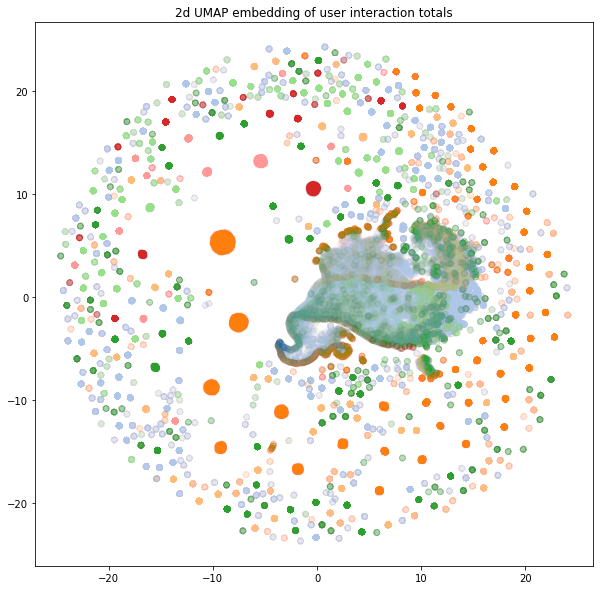

In [118]:
Y = embedding
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.scatter(Y[:, 0], Y[:, 1], alpha=0.01, c=[plt.cm.tab20((cluster + 1) / num_clusters) for cluster in clusters])
plt.title("2d UMAP embedding of user interaction totals")
plt.show()

Not clear that the UMAP embedding reveals any particularly interesting structure in the data.

## Merge with journal data

In [29]:
amps_df['int_type'] = 'amps'

In [31]:
ints_df = pd.concat([gb_df, comments_df, amps_df.drop(columns='journal_user_id')], sort=False)
ints_df.reset_index(drop=True, inplace=True)
len(ints_df)

10495558

In [34]:
assert len(ints_df) == len(gb_df) + len(amps_df) + len(comments_df)

In [32]:
ints_df.columns

Index(['user_id', 'site_id', 'int_type', 'created_at', 'updated_at',
       'journal_oid'],
      dtype='object')

In [38]:
ints_df.head()

,user_id,site_id,int_type,created_at,updated_at,journal_oid
0,322059,20005,guestbook,1371420989000,1371420989000,NaN
1,5968472,68593,guestbook,1371432498000,1371432498000,NaN
2,21573557,557835,guestbook,1371429583000,1371429583000,NaN
3,20049997,77628,guestbook,1371440716000,1371440716000,NaN
4,24353953,604503,guestbook,1371442462000,1371442462000,NaN


In [35]:
# load the journal metadata
# load the dataframe with the index
s = datetime.now()
journal_metadata_dir = "/home/srivbane/shared/caringbridge/data/derived/journal_metadata"
journal_metadata_filepath = os.path.join(journal_metadata_dir, "journal_metadata.df")
journal_df = pd.read_feather(journal_metadata_filepath)
print(datetime.now() - s)
len(journal_df)

0:00:24.082178


17893390

In [36]:
journal_df.head()

,created_at,journal_oid,published_at,site_id,updated_at,user_id,site_index,is_nontrivial
0,1103856900000,51bdf3e56ca0048f4e00ced4,0,1,1103856900000,1,0,True
1,1103943240000,51bdf3e56ca0048f4e00ced2,0,1,1103943240000,1,1,True
2,1104288840000,51bdf3e56ca0048f4e00ced0,0,1,1104288840000,1,2,True
3,1104461640000,51bdf3e56ca0048f4e00cece,0,1,1104461640000,1,3,True
4,1104807180000,51bdf3e56ca0048f4e00cecc,0,1,1104807180000,1,4,True


In [37]:
journal_df['int_type'] = 'journal'

In [39]:
journal_cols = ['user_id', 'site_id', 'int_type', 'created_at', 'updated_at', 'journal_oid', 'site_index', 'is_nontrivial']
merged_df = pd.concat([ints_df, journal_df[journal_cols]], sort=False)
assert len(merged_df) == len(ints_df) + len(journal_df)
len(merged_df)

28388948

In [40]:
merged_df.head()

,user_id,site_id,int_type,created_at,updated_at,journal_oid,site_index,is_nontrivial
0,322059,20005,guestbook,1371420989000,1371420989000,NaN,NaN,NaN
1,5968472,68593,guestbook,1371432498000,1371432498000,NaN,NaN,NaN
2,21573557,557835,guestbook,1371429583000,1371429583000,NaN,NaN,NaN
3,20049997,77628,guestbook,1371440716000,1371440716000,NaN,NaN,NaN
4,24353953,604503,guestbook,1371442462000,1371442462000,NaN,NaN,NaN


In [42]:
# construct a map of (user_id) -> set(site_id)
# captures all sites on which a user_id has authored at least a single journal update
author_site_map = defaultdict(set)
for user_id, site_id in tqdm(zip(journal_df.user_id, journal_df.site_id), total=len(journal_df)):
    author_site_map[user_id].add(site_id)

100%|██████████| 17893390/17893390 [00:16<00:00, 1098754.02it/s]


In [46]:
s = datetime.now()
merged_df = merged_df.assign(is_self_interaction=merged_df.apply(lambda row: row.site_id in author_site_map[row.user_id], axis=1))
print(datetime.now() - s)

0:14:41.643676


In [44]:
# quickly verify that journal OIDs are unique
assert len(journal_df) == len(set(journal_df.journal_oid))

In [45]:
journal_oid_index_map = {journal_oid: site_index
    for journal_oid, site_index in zip(journal_df.journal_oid, journal_df.site_index)
}

In [47]:
merged_df.head()

,user_id,site_id,int_type,created_at,updated_at,journal_oid,site_index,is_nontrivial,is_self_interaction
0,322059,20005,guestbook,1371420989000,1371420989000,NaN,NaN,NaN,True
1,5968472,68593,guestbook,1371432498000,1371432498000,NaN,NaN,NaN,False
2,21573557,557835,guestbook,1371429583000,1371429583000,NaN,NaN,NaN,True
3,20049997,77628,guestbook,1371440716000,1371440716000,NaN,NaN,NaN,False
4,24353953,604503,guestbook,1371442462000,1371442462000,NaN,NaN,NaN,False


In [52]:
no_journal_count = len(merged_df[pd.isnull(merged_df.journal_oid)]) / len(merged_df)
guestbook_count = len(merged_df[merged_df.int_type == 'guestbook']) / len(merged_df)
assert no_journal_count == guestbook_count

In [55]:
# add site_index info to all interactions with a journal_oid
s = datetime.now()
merged_df.loc[~pd.isnull(merged_df.journal_oid), 'site_index'] = merged_df.loc[~pd.isnull(merged_df.journal_oid), 'journal_oid'].map(lambda journal_oid: journal_oid_index_map[journal_oid] if journal_oid in journal_oid_index_map else -1)
print(datetime.now() - s)

0:00:20.521665


In [56]:
# only 229 journals are reference by a journal oid that we don't have in the journal data
ints_journal_oid_set = set(ints_df.journal_oid)
journals_journal_oid_set = set(journal_df.journal_oid)
len(ints_journal_oid_set - journals_journal_oid_set)

229

In [57]:
len(merged_df[merged_df.site_index == -1])

259

In [60]:
merged_df.reset_index(drop=True, inplace=True)

In [61]:
merged_df.head()

,user_id,site_id,int_type,created_at,updated_at,journal_oid,site_index,is_nontrivial,is_self_interaction
0,322059,20005,guestbook,1371420989000,1371420989000,NaN,NaN,NaN,True
1,5968472,68593,guestbook,1371432498000,1371432498000,NaN,NaN,NaN,False
2,21573557,557835,guestbook,1371429583000,1371429583000,NaN,NaN,NaN,True
3,20049997,77628,guestbook,1371440716000,1371440716000,NaN,NaN,NaN,False
4,24353953,604503,guestbook,1371442462000,1371442462000,NaN,NaN,NaN,False


In [63]:
user_metadata_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/user_metadata"
interaction_metadata_filepath = os.path.join(user_metadata_dir, "interaction_metadata.feather")
merged_df.to_feather(interaction_metadata_filepath)
print("Finished.")

Finished.


#### HDF5 storage

Need to convert mixed-type columns

In [65]:
merged_df.loc[pd.isnull(merged_df.journal_oid), 'journal_oid'] = ""

In [66]:
merged_df.loc[pd.isnull(merged_df.site_index), 'site_index'] = -1

In [67]:
merged_df.loc[pd.isnull(merged_df.is_nontrivial), 'is_nontrivial'] = True

In [68]:
# also write to a HDF5 datastore 
s = datetime.now()
hdf5_store_filepath = os.path.join(user_metadata_dir, "interaction_metadata.h5")
store = pd.HDFStore(hdf5_store_filepath)
try:
    store.append('user_ints_df', merged_df, data_columns=True)
finally:
    store.close()
print(datetime.now() - s)

0:06:37.654953


In [69]:
# test querying data for a specific user
s = datetime.now()
user_metadata_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/user_metadata"
hdf5_store_filepath = os.path.join(user_metadata_dir, "interaction_metadata.h5")
store = pd.HDFStore(hdf5_store_filepath)
try:
    user_df = store.select('user_ints_df', where=['user_id == 173825'])
finally:
    store.close()
print(datetime.now() - s)
len(user_df)

0:00:00.208699


185

In [70]:
user_df

,user_id,site_id,int_type,created_at,updated_at,journal_oid,site_index,is_nontrivial,is_self_interaction
246502,173825,5664,guestbook,1130914183000,1130914183000,,-1.0,True,True
246940,173825,5664,guestbook,1133578568000,1133578568000,,-1.0,True,True
247308,173825,5664,guestbook,1135728620000,1135728620000,,-1.0,True,True
333476,173825,7704,guestbook,1135665632000,1135665632000,,-1.0,True,True
432501,173825,9864,guestbook,1146544031000,1146544031000,,-1.0,True,False
1230560,173825,28484,guestbook,1198125465000,1198125465000,,-1.0,True,False
1605088,173825,39490,guestbook,1182485501000,1182485501000,,-1.0,True,True
1673719,173825,41767,guestbook,1190085075000,1190085075000,,-1.0,True,False
3099368,173825,301700,guestbook,1323807318000,1323807318000,,-1.0,True,False
3452523,173825,110537,guestbook,1234150285000,1234150285000,,-1.0,True,False


In [ ]:
# TODO Having identified self-interactions, produce percentages of each user that does self-interactions 
# (and percentage of each interaction that is a self-interaction)